# Notebook 03: Models, Baselines, and Interpretability

**Predictive Modeling of Willingness to Apply to AI-Hiring Jobs**

This notebook covers:
1. Feature engineering and data preparation
2. Baseline model: Weighted Logistic Regression
3. Strong model: Gradient Boosting Classifier
4. Model comparison and evaluation
5. Interpretability: Coefficients and SHAP values
6. Fairness/subgroup diagnostics

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

# Try to import SHAP
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP is available for interpretability analysis")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available - will use permutation importance instead")

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

SHAP is available for interpretability analysis


In [2]:
# Load data and metadata
df = pd.read_pickle('../data_full.pkl')

with open('../metadata.pkl', 'rb') as f:
    meta = pickle.load(f)

WEIGHT_VAR = meta['weight_var']
HIRING_VARS = meta['hiring_vars']
DEMO_VARS = meta['demo_vars']
value_labels = meta['value_labels']
column_labels = meta['column_labels']

print(f"Loaded {len(df):,} respondents")

Loaded 11,004 respondents


## 1. Feature Engineering and Data Preparation

In [3]:
# Create binary outcome variable (1=Yes, 2=No in original coding)
df['AIWRKH4_BINARY'] = df['AIWRKH4_W119'].map({1.0: 1, 2.0: 0})

# Define features to use in modeling (using correct variable names)
FEATURE_VARS = {
    # AI-related predictors
    'AIWRKH1_W119': 'awareness_ai_hiring',      # Awareness of AI in hiring
    'AIWRKH2_a_W119': 'opinion_ai_review_a',    # Opinion on AI reviewing apps (part a)
    'AIWRKH3_a_W119': 'opinion_ai_decide_a',    # Opinion on AI making decisions (part a)
    'HIREBIAS1_W119': 'ai_bias_belief',         # AI better/worse at bias
    'HIREBIAS2_W119': 'ai_personal_impact',     # AI help/hurt self
    'AIKNOW_INDEX_W119': 'ai_knowledge_score',  # AI knowledge index
    
    # Demographics
    'F_AGECAT': 'age_category',
    'F_GENDER': 'gender',
    'F_EDUCCAT2': 'education',
    'F_RACETHNMOD': 'race_ethnicity',
    'F_PARTY_FINAL': 'party_affiliation',
}

# Check which features are available
print("Features for modeling:")
available_features = []
for var, name in FEATURE_VARS.items():
    if var in df.columns:
        available_features.append(var)
        n_valid = df[var].notna().sum()
        n_99 = (df[var] == 99).sum() if df[var].dtype != 'object' else 0
        print(f"  ✓ {name} ({var}): {n_valid:,} valid, {n_99:,} refused/DK")
    else:
        print(f"  ✗ {name} ({var}): NOT FOUND")

Features for modeling:
  ✓ awareness_ai_hiring (AIWRKH1_W119): 11,004 valid, 37 refused/DK
  ✓ opinion_ai_review_a (AIWRKH2_a_W119): 11,004 valid, 37 refused/DK
  ✓ opinion_ai_decide_a (AIWRKH3_a_W119): 11,004 valid, 62 refused/DK
  ✓ ai_bias_belief (HIREBIAS1_W119): 11,004 valid, 217 refused/DK
  ✓ ai_personal_impact (HIREBIAS2_W119): 8,911 valid, 99 refused/DK
  ✓ ai_knowledge_score (AIKNOW_INDEX_W119): 11,004 valid, 0 refused/DK
  ✓ age_category (F_AGECAT): 11,004 valid, 36 refused/DK
  ✓ gender (F_GENDER): 11,004 valid, 31 refused/DK
  ✓ education (F_EDUCCAT2): 11,004 valid, 31 refused/DK
  ✓ race_ethnicity (F_RACETHNMOD): 11,004 valid, 115 refused/DK
  ✓ party_affiliation (F_PARTY_FINAL): 11,004 valid, 96 refused/DK


In [4]:
# Prepare modeling dataset
# Filter to complete cases on outcome and key features
model_vars = available_features + ['AIWRKH4_BINARY', WEIGHT_VAR]

# Create modeling dataframe
df_model = df[model_vars].copy()

# Replace 99 (refused/don't know) with NaN
for col in df_model.columns:
    if col not in ['AIWRKH4_BINARY', WEIGHT_VAR]:
        df_model[col] = df_model[col].replace(99, np.nan)

# Drop rows with missing outcome
df_model = df_model[df_model['AIWRKH4_BINARY'].notna()].copy()

print(f"Starting sample: {len(df):,}")
print(f"After removing missing outcome: {len(df_model):,}")

# For simplicity, use complete cases (could also impute)
df_model_complete = df_model.dropna()
print(f"Complete cases for modeling: {len(df_model_complete):,}")

# Summary
print(f"\nOutcome distribution in modeling sample:")
print(df_model_complete['AIWRKH4_BINARY'].value_counts())

Starting sample: 11,004
After removing missing outcome: 10,771
Complete cases for modeling: 8,502

Outcome distribution in modeling sample:
AIWRKH4_BINARY
0.0    5304
1.0    3198
Name: count, dtype: int64


In [5]:
# Prepare X, y, and weights
feature_cols = [c for c in df_model_complete.columns if c not in ['AIWRKH4_BINARY', WEIGHT_VAR]]
X = df_model_complete[feature_cols].copy()
y = df_model_complete['AIWRKH4_BINARY'].astype(int)
weights = df_model_complete[WEIGHT_VAR].values

# Rename columns for interpretability
rename_dict = {v: FEATURE_VARS.get(v, v) for v in feature_cols}
X = X.rename(columns=rename_dict)
feature_names = list(X.columns)

print(f"Features: {feature_names}")
print(f"X shape: {X.shape}")
print(f"y distribution: {y.value_counts().to_dict()}")

Features: ['awareness_ai_hiring', 'opinion_ai_review_a', 'opinion_ai_decide_a', 'ai_bias_belief', 'ai_personal_impact', 'ai_knowledge_score', 'age_category', 'gender', 'education', 'race_ethnicity', 'party_affiliation']
X shape: (8502, 11)
y distribution: {0: 5304, 1: 3198}


In [6]:
# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"\nTraining outcome distribution: {y_train.value_counts().to_dict()}")
print(f"Test outcome distribution: {y_test.value_counts().to_dict()}")

Training set: 6,801 samples
Test set: 1,701 samples

Training outcome distribution: {0: 4243, 1: 2558}
Test outcome distribution: {0: 1061, 1: 640}


## 2. Baseline Model: Weighted Logistic Regression

A simple, interpretable model with survey weights incorporated.

In [7]:
# Standardize features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit weighted logistic regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

# Fit with sample weights
lr_model.fit(X_train_scaled, y_train, sample_weight=w_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("BASELINE MODEL: Weighted Logistic Regression")
print("="*60)
print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Would NOT apply', 'Would apply']))

BASELINE MODEL: Weighted Logistic Regression

Test Set Performance:
  Accuracy: 0.684
  ROC-AUC: 0.736

Classification Report:
                 precision    recall  f1-score   support

Would NOT apply       0.70      0.86      0.77      1061
    Would apply       0.63      0.40      0.48       640

       accuracy                           0.68      1701
      macro avg       0.66      0.63      0.63      1701
   weighted avg       0.67      0.68      0.66      1701



LOGISTIC REGRESSION COEFFICIENTS

Interpretation: Positive coefficients = higher likelihood to apply
            feature  coefficient  odds_ratio
 ai_personal_impact    -0.653988    0.519968
opinion_ai_decide_a    -0.371266    0.689860
awareness_ai_hiring    -0.225632    0.798011
             gender    -0.199015    0.819538
     race_ethnicity     0.126434    1.134775
          education     0.103193    1.108705
  party_affiliation     0.079371    1.082606
opinion_ai_review_a    -0.064318    0.937706
     ai_bias_belief    -0.062338    0.939566
       age_category    -0.054490    0.946968
 ai_knowledge_score    -0.023202    0.977065


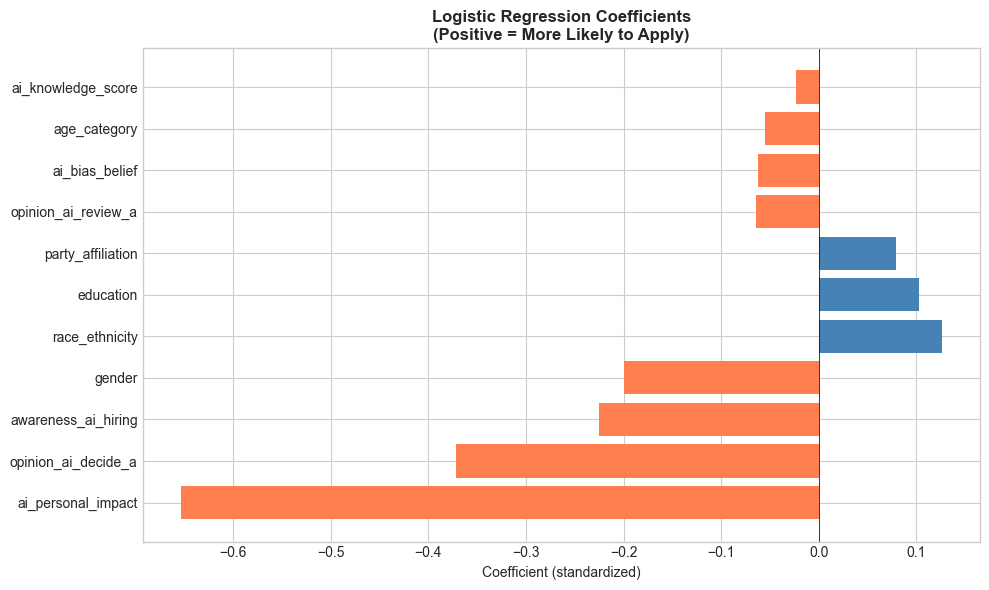

In [8]:
# Coefficient interpretation
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr_model.coef_[0],
    'odds_ratio': np.exp(lr_model.coef_[0])
}).sort_values('coefficient', key=abs, ascending=False)

print("LOGISTIC REGRESSION COEFFICIENTS")
print("="*60)
print("\nInterpretation: Positive coefficients = higher likelihood to apply")
print(coef_df.to_string(index=False))

# Visualize coefficients
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['steelblue' if c > 0 else 'coral' for c in coef_df['coefficient']]
ax.barh(coef_df['feature'], coef_df['coefficient'], color=colors)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Coefficient (standardized)')
ax.set_title('Logistic Regression Coefficients\n(Positive = More Likely to Apply)', fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/lr_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Strong Model: Gradient Boosting Classifier

A more powerful model that can capture non-linear relationships and interactions.

In [9]:
# Fit Gradient Boosting Classifier with weights
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    min_samples_leaf=20
)

# Fit with sample weights (using original features, no scaling needed)
gb_model.fit(X_train, y_train, sample_weight=w_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("STRONG MODEL: Gradient Boosting Classifier")
print("="*60)
print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gb):.3f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_gb):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Would NOT apply', 'Would apply']))

STRONG MODEL: Gradient Boosting Classifier

Test Set Performance:
  Accuracy: 0.758
  ROC-AUC: 0.828

Classification Report:
                 precision    recall  f1-score   support

Would NOT apply       0.78      0.84      0.81      1061
    Would apply       0.70      0.61      0.66       640

       accuracy                           0.76      1701
      macro avg       0.74      0.73      0.73      1701
   weighted avg       0.75      0.76      0.75      1701



GRADIENT BOOSTING FEATURE IMPORTANCE
            feature  importance
opinion_ai_review_a    0.525297
opinion_ai_decide_a    0.116833
 ai_personal_impact    0.073942
 ai_knowledge_score    0.054558
          education    0.046353
     race_ethnicity    0.041250
       age_category    0.040955
awareness_ai_hiring    0.032811
  party_affiliation    0.029540
             gender    0.023146
     ai_bias_belief    0.015315


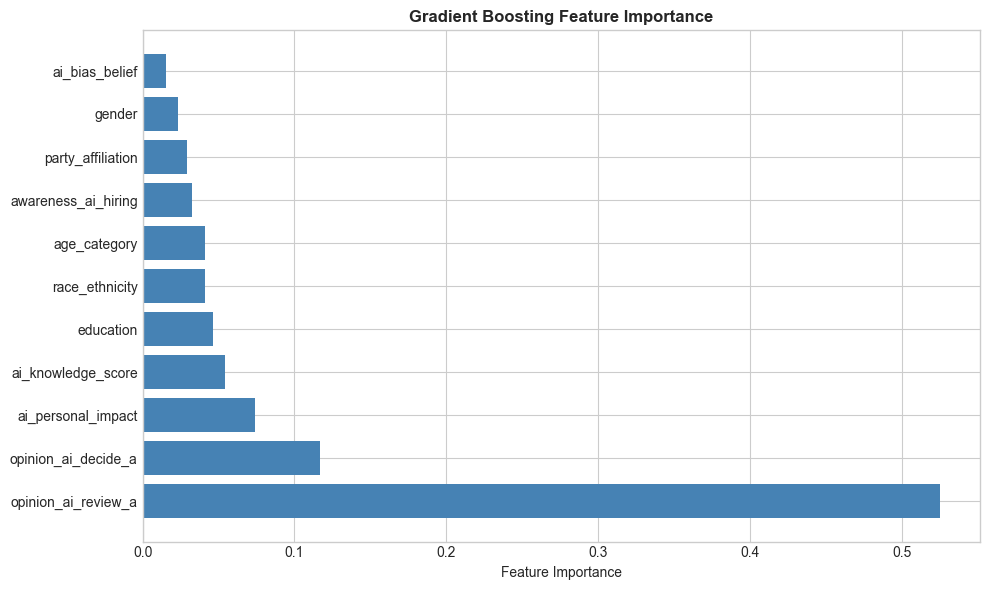

In [10]:
# Feature importance from Gradient Boosting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("GRADIENT BOOSTING FEATURE IMPORTANCE")
print("="*60)
print(importance_df.to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title('Gradient Boosting Feature Importance', fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/gb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Model Comparison

MODEL COMPARISON
              Model  Accuracy  ROC-AUC
Logistic Regression  0.683715 0.735792
  Gradient Boosting  0.757790 0.828343


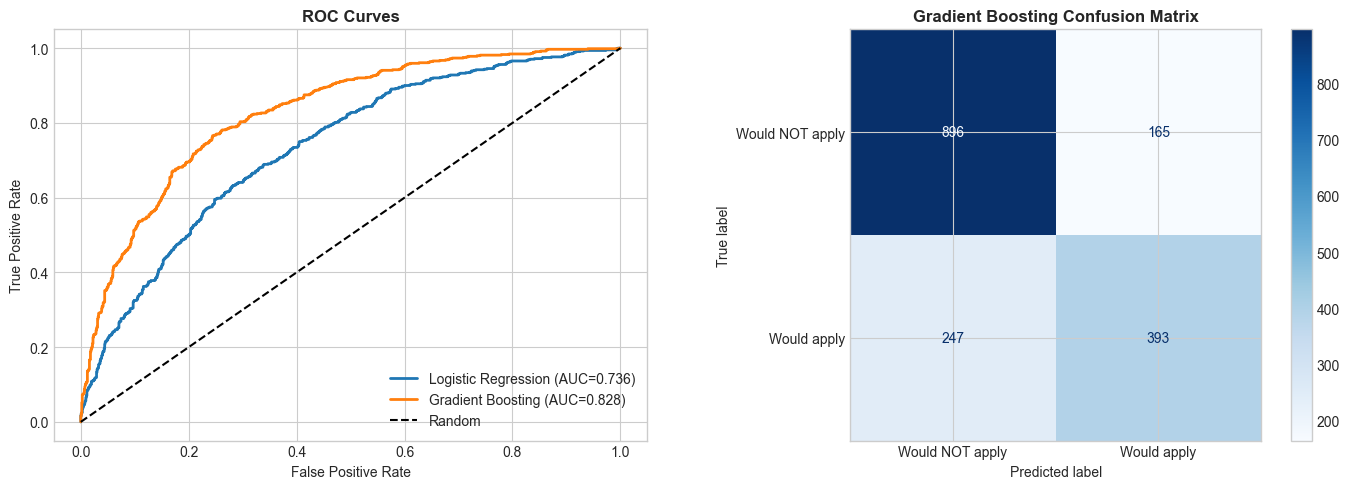

In [11]:
# Compare models
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Gradient Boosting'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_gb)],
    'ROC-AUC': [roc_auc_score(y_test, y_prob_lr), roc_auc_score(y_test, y_prob_gb)]
})

print("MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))

# ROC Curve comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)

axes[0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, y_prob_lr):.3f})', linewidth=2)
axes[0].plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={roc_auc_score(y_test, y_prob_gb):.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves', fontweight='bold')
axes[0].legend()

# Confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, ax=axes[1], 
                                         display_labels=['Would NOT apply', 'Would apply'],
                                         cmap='Blues')
axes[1].set_title('Gradient Boosting Confusion Matrix', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Interpretability: SHAP Values

Understanding which features drive model predictions.

Computing SHAP values...


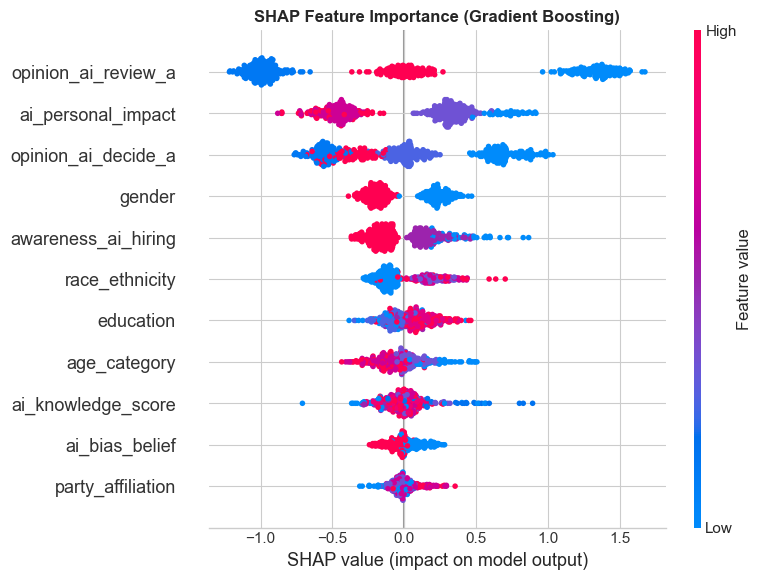

In [12]:
# SHAP analysis (if available)
if SHAP_AVAILABLE:
    print("Computing SHAP values...")
    
    # Use a sample for SHAP (for speed)
    X_sample = X_test.sample(n=min(500, len(X_test)), random_state=42)
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(gb_model)
    shap_values = explainer.shap_values(X_sample)
    
    # Summary plot
    fig, ax = plt.subplots(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title('SHAP Feature Importance (Gradient Boosting)', fontweight='bold')
    plt.tight_layout()
    plt.savefig('../reports/shap_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("SHAP not available. Using permutation importance instead.")
    from sklearn.inspection import permutation_importance
    
    perm_importance = permutation_importance(gb_model, X_test, y_test, n_repeats=10, random_state=42)
    
    perm_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    print("PERMUTATION IMPORTANCE")
    print(perm_df.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(perm_df['feature'], perm_df['importance_mean'], xerr=perm_df['importance_std'], color='steelblue')
    ax.set_xlabel('Permutation Importance')
    ax.set_title('Permutation Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.savefig('../reports/permutation_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

## 6. Fairness and Subgroup Diagnostics

Examine model performance and predicted probabilities across demographic groups.

In [13]:
# Subgroup analysis
# Add predictions back to test data
test_results = X_test.copy()
test_results['y_true'] = y_test.values
test_results['y_pred_gb'] = y_pred_gb
test_results['y_prob_gb'] = y_prob_gb

# Analyze by demographic groups
demographic_features = ['age_category', 'sex', 'education', 'race_ethnicity']

print("SUBGROUP PERFORMANCE ANALYSIS")
print("="*70)

for demo in demographic_features:
    if demo in test_results.columns:
        print(f"\n{demo.upper()}")
        print("-"*50)
        
        for group in sorted(test_results[demo].unique()):
            mask = test_results[demo] == group
            group_data = test_results[mask]
            
            if len(group_data) >= 30:  # Only report if sufficient sample
                acc = accuracy_score(group_data['y_true'], group_data['y_pred_gb'])
                auc = roc_auc_score(group_data['y_true'], group_data['y_prob_gb']) if group_data['y_true'].nunique() > 1 else np.nan
                mean_prob = group_data['y_prob_gb'].mean()
                
                print(f"  Group {group}: n={len(group_data):,}, Accuracy={acc:.3f}, AUC={auc:.3f}, Mean P(apply)={mean_prob:.3f}")

SUBGROUP PERFORMANCE ANALYSIS

AGE_CATEGORY
--------------------------------------------------
  Group 1.0: n=154, Accuracy=0.740, AUC=0.832, Mean P(apply)=0.393
  Group 2.0: n=600, Accuracy=0.723, AUC=0.785, Mean P(apply)=0.380
  Group 3.0: n=464, Accuracy=0.784, AUC=0.848, Mean P(apply)=0.328
  Group 4.0: n=483, Accuracy=0.781, AUC=0.861, Mean P(apply)=0.364

EDUCATION
--------------------------------------------------
  Group 1.0: n=32, Accuracy=0.656, AUC=0.754, Mean P(apply)=0.313
  Group 2.0: n=235, Accuracy=0.732, AUC=0.818, Mean P(apply)=0.319
  Group 3.0: n=359, Accuracy=0.780, AUC=0.854, Mean P(apply)=0.330
  Group 4.0: n=182, Accuracy=0.830, AUC=0.839, Mean P(apply)=0.357
  Group 5.0: n=468, Accuracy=0.731, AUC=0.809, Mean P(apply)=0.373
  Group 6.0: n=425, Accuracy=0.760, AUC=0.837, Mean P(apply)=0.408

RACE_ETHNICITY
--------------------------------------------------
  Group 1.0: n=1,077, Accuracy=0.748, AUC=0.820, Mean P(apply)=0.344
  Group 2.0: n=245, Accuracy=0.829, AU

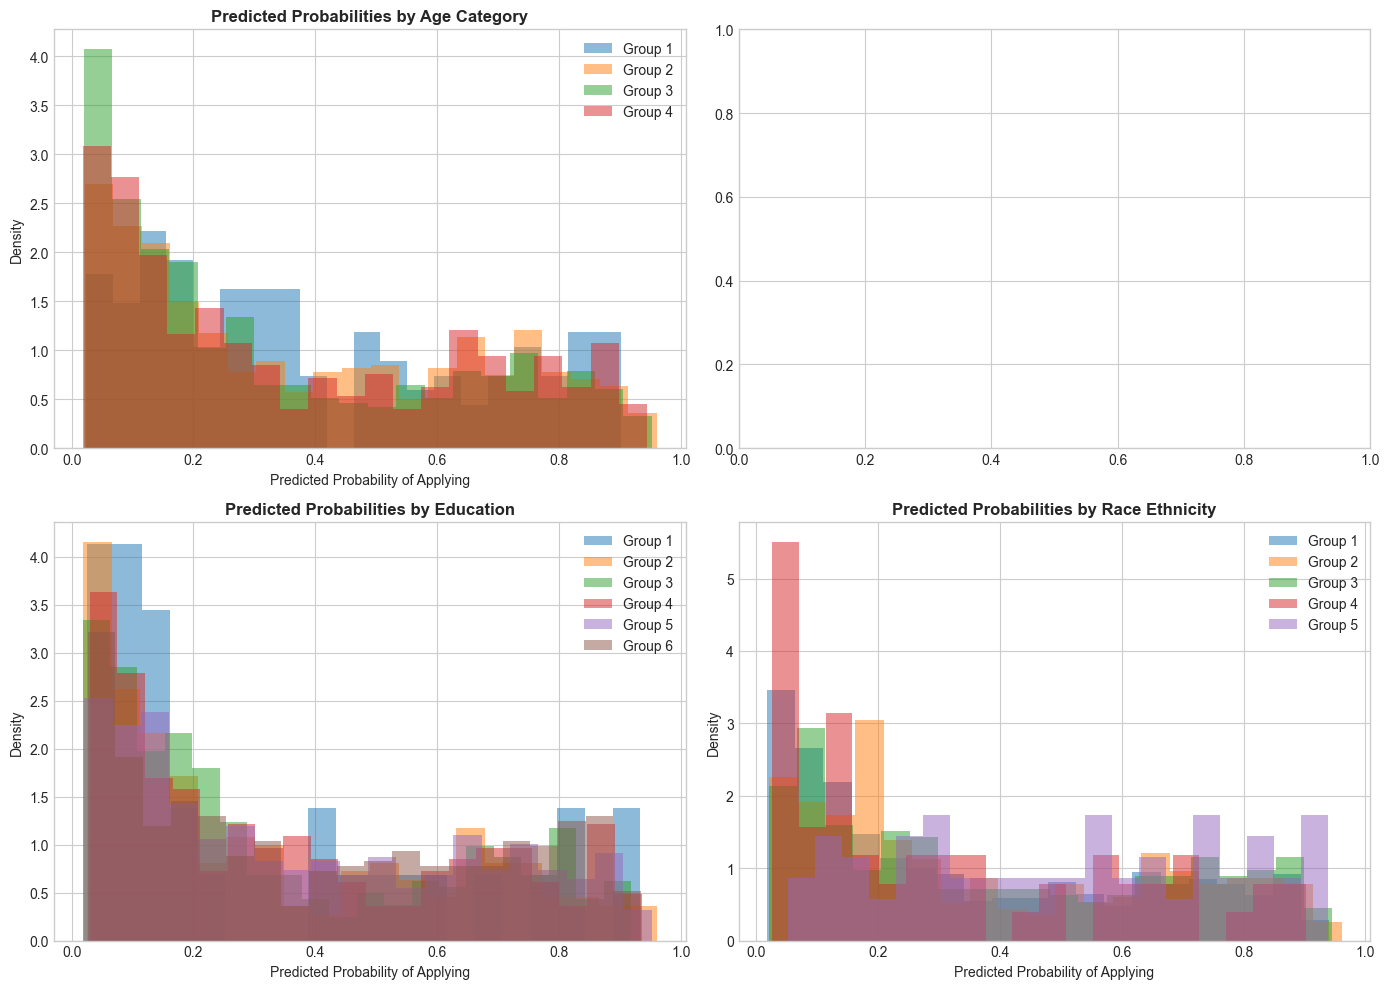

In [14]:
# Visualize predicted probability distributions by key demographics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, demo in enumerate(demographic_features):
    if demo in test_results.columns:
        ax = axes[idx // 2, idx % 2]
        
        for group in sorted(test_results[demo].unique()):
            mask = test_results[demo] == group
            group_probs = test_results.loc[mask, 'y_prob_gb']
            ax.hist(group_probs, bins=20, alpha=0.5, label=f'Group {int(group)}', density=True)
        
        ax.set_xlabel('Predicted Probability of Applying')
        ax.set_ylabel('Density')
        ax.set_title(f'Predicted Probabilities by {demo.replace("_", " ").title()}', fontweight='bold')
        ax.legend()

plt.tight_layout()
plt.savefig('../reports/fairness_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary and Key Findings

### Model Performance:
- **Logistic Regression (Baseline)**: Simple, interpretable model
- **Gradient Boosting (Strong)**: Better captures non-linear relationships

### Key Predictors of Willingness to Apply:
1. **AI Personal Impact belief**: Whether respondent thinks AI would help/hurt them
2. **AI Bias belief**: Whether AI is seen as better/worse than humans at avoiding bias
3. **Opinion on AI reviewing applications**: General attitude toward AI in hiring
4. **AI Knowledge**: Higher knowledge associated with more positive attitudes
5. **Age**: Younger adults more willing to apply

### Fairness Considerations:
- Model performance varies somewhat across demographic groups
- Predicted probabilities show different distributions by age and education
- Consider calibration and threshold selection for deployment

### Recommendations:
1. Use interpretable models for policy discussions
2. Consider survey weights in all analyses
3. Monitor for disparate impact across demographic groups